# Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import researchpy as rp
import re
import featuretools as ft
from sklearn.impute import SimpleImputer
from functools import reduce


import mlflow
import mlflow.sklearn
import mlflow.lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

In [51]:
pd.set_option('display.max_colwidth', None)

push test

# Fonctions

In [52]:
def dataset_overview(df):
    """
    Provides a comprehensive overview of a pandas DataFrame including:
    - Shape of the dataset
    - Column names and data types
    - Missing values
    - Basic statistics for numeric columns
    - Unique values for categorical columns
    """

    print("="*80)
    print("DATASET OVERVIEW")
    print("="*80)

    # Basic info
    print("\nDATASET SHAPE:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\nCOLUMN INFORMATION:")
    print(df.dtypes.to_string())

    # Missing values
    print("\nMISSING VALUES:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing,
                              'Percentage (%)': missing_percent.round(2)})
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage (%)', ascending=False))

    # Numeric columns statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("\nNUMERIC COLUMNS STATISTICS:")
        print(df[numeric_cols].describe().transpose()[['mean', '50%', 'std', 'min', 'max']]
              .rename(columns={'50%': 'median'}))

    # Categorical columns statistics
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nCATEGORICAL COLUMNS STATISTICS:")
        for col in cat_cols:
            print(f"\nColumn: {col}")
            print(f"Unique values: {df[col].nunique()}")
            print("Top 5 values:")
            print(df[col].value_counts().head())

    print("="*80)

In [53]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## Fonction pour aggrégation valeurs numériques

In [54]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

## Fonction pour aggréger variables catégorielles

In [55]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

# Chargement datasets

In [56]:
HomeCredit_ini = pd.read_csv('data/HomeCredit_columns_description.csv', encoding='latin-1')
POS_CASH_balance_ini = pd.read_csv('data/POS_CASH_balance.csv')
installments_payments_ini = pd.read_csv('data/installments_payments.csv')
previous_application_ini = pd.read_csv('data/previous_application.csv')
application_test_ini = pd.read_csv('data/application_test.csv')
application_train_ini = pd.read_csv('data/application_train.csv')
bureau_balance_ini = pd.read_csv('data/bureau_balance.csv')
bureau_ini = pd.read_csv('data/bureau.csv')
sample_submission_ini = pd.read_csv('data/sample_submission.csv')
credit_card_balance_ini = pd.read_csv('data/credit_card_balance.csv')
features_manual_and_func_from_first_three_with_app_train_ini = pd.read_csv('data/features_manual_and_func_from_first_three_with_app_train.csv')

In [57]:
HomeCredit = HomeCredit_ini.copy()
POS_CASH_balance = POS_CASH_balance_ini.copy()
installments_payments = installments_payments_ini.copy()
previous_application = previous_application_ini.copy()
application_test = application_test_ini.copy()
application_train = application_train_ini.copy()
bureau_balance = bureau_balance_ini.copy()
bureau = bureau_ini.copy()
sample_submission = sample_submission_ini.copy()
credit_card_balance = credit_card_balance_ini.copy()
features_manual_and_func_from_first_three_with_app_train = features_manual_and_func_from_first_three_with_app_train_ini.copy()

# Rappel précédent notebook et étapes à suivre

Au cours du précédent notebook on a pu réaliser plusieurs runs avec LightBGM en utilisant les données des trois premiers datasets qui sont : application_train, bureau et bureau_balance avec des feature créees manuellement, des features créees avec les fonctions d'aggrégation pour les variables numériques et catégorielles et aussi des features créees avec feature tools. Les résultats n'étant pas concluants on va ajouter les données contenues dans les autres datasets. On ne va pas aller autant en détail notamment du à un manque de connaissances métier.

Les étapes à suivre sont les suivantes : - Obtenir les features des autres DataFrames
                                         - Tout regrouper en un seul DataFrame
                                         - Réaliser un test initial avec LightGBM en introduisant de la crossvalidation et réaliser un peu de fine tuning
                                         - Analyser les corrélations et éventuellement retirer les variables trop corréelées entre elles
                                         - Relancer LightBGM
                                         - Analyser la feature importance et voir si l'on peut se débarasser du bruit
                                         - Relancer LightGBM
                                         - Aller plus en détail sur la feature importance
                                         - Si l'on suppose que le coût d'un FN (client ne pouvant pas rembourser le prêt mais prédit comme pouvant le rembourser) est 10 fois plus supérieur à celui d'un FP on peut introduire des poids dans notre modèle
                                         - Relancer LightGBM et analyser/optimiser le seuil de décision
                                         - Plus de fine tuning avec GridSearchCV
                                         - Tout au long de ces analyses comparer les résultats en utilisant ROC AUC et les différentes métriques liées au matrices de confusion

# Overview des DataFrames

Même si on pourrait fusionner certains de ces DataFrames avant on va éviter sinon les aggrégations avec la moyenne par exemple pourraient être faussées/introduction de biais

In [58]:
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [59]:
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [60]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [61]:
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


# Aggrégation des DataFrames

## Aggrégation de previous_application

### Overview

In [62]:
previous_application['SK_ID_PREV'].nunique()

1670214

### Aggrégation

In [63]:
previous_application_num_agg_SK_ID_CURR = agg_numeric(previous_application.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='previous_application')
previous_application_num_agg_SK_ID_CURR

,SK_ID_CURR,previous_application_AMT_ANNUITY_count,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_count,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,...,previous_application_DAYS_TERMINATION_count,previous_application_DAYS_TERMINATION_mean,previous_application_DAYS_TERMINATION_max,previous_application_DAYS_TERMINATION_min,previous_application_DAYS_TERMINATION_sum,previous_application_NFLAG_INSURED_ON_APPROVAL_count,previous_application_NFLAG_INSURED_ON_APPROVAL_mean,previous_application_NFLAG_INSURED_ON_APPROVAL_max,previous_application_NFLAG_INSURED_ON_APPROVAL_min,previous_application_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000,3951.000,3951.000,1,24835.500,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775000,9251.775,9251.775,9251.775,1,179055.000,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.990000,98356.995,6737.310,169661.970,3,435436.500,900000.0,68809.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250,5357.250,5357.250,1,24282.000,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200000,4813.200,4813.200,4813.200,2,22308.750,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1,6605.910000,6605.910,6605.910,6605.910,1,40455.000,40455.0,40455.0,...,1,-25.000000,-25.0,-25.0,-25.0,1,0.000000,0.0,0.0,0.0
338853,456252,1,10074.465000,10074.465,10074.465,10074.465,1,57595.500,57595.5,57595.5,...,1,-2311.000000,-2311.0,-2311.0,-2311.0,1,1.000000,1.0,1.0,1.0
338854,456253,2,4770.405000,5567.715,3973.095,9540.810,2,24162.750,28912.5,19413.0,...,2,-2212.500000,-1712.0,-2713.0,-4425.0,2,0.500000,1.0,0.0,1.0
338855,456254,2,10681.132500,19065.825,2296.440,21362.265,2,121317.750,223789.5,18846.0,...,2,365243.000000,365243.0,365243.0,730486.0,2,0.500000,1.0,0.0,1.0


In [64]:
previous_application_cat_agg_SK_ID_CURR = count_categorical(previous_application.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='previous_application')
previous_application_cat_agg_SK_ID_CURR

,previous_application_NAME_CONTRACT_TYPE_Cash loans_count,previous_application_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_application_NAME_CONTRACT_TYPE_XNA_count,previous_application_NAME_CONTRACT_TYPE_XNA_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_application_PRODUCT_COMBINATION_POS industry without interest_count,previous_application_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.000,0,0.0,1,1.000000,...,0,0.0,1,1.00,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,0,0.00,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.000,0,0.0,1,0.333333,...,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.000,0,0.0,1,1.000000,...,0,0.0,0,0.00,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.000,0,0.0,1,0.500000,...,0,0.0,1,0.50,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0,0.000000,1,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,1,1.00,0,0.0,0,0.0,0,0.0
456252,0,0.000000,1,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0
456253,0,0.000000,2,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,2,1.00,0,0.0,0,0.0,0,0.0


### Feature names

In [65]:
# previous_application_num_agg_SK_ID_CURR and previous_application_cat_agg_SK_ID_CURR

## Aggrégation de POS_CASH_BALANCE

### Overview

In [66]:
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [67]:
POS_CASH_balance['SK_ID_PREV'].nunique()

936325

In [68]:
POS_CASH_balance['SK_ID_CURR'].nunique()

337252

In [69]:
HomeCredit[HomeCredit['Table'] == 'POS_CASH_balance.csv']

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previous credit,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,NaN


### Aggrégation

In [70]:
POS_CASH_balance_num_agg_SK_ID_CURR = agg_numeric(POS_CASH_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='POS_CASH_balance')
POS_CASH_balance_num_agg_SK_ID_CURR

,SK_ID_CURR,POS_CASH_balance_MONTHS_BALANCE_count,POS_CASH_balance_MONTHS_BALANCE_mean,POS_CASH_balance_MONTHS_BALANCE_max,POS_CASH_balance_MONTHS_BALANCE_min,POS_CASH_balance_MONTHS_BALANCE_sum,POS_CASH_balance_CNT_INSTALMENT_count,POS_CASH_balance_CNT_INSTALMENT_mean,POS_CASH_balance_CNT_INSTALMENT_max,POS_CASH_balance_CNT_INSTALMENT_min,...,POS_CASH_balance_SK_DPD_count,POS_CASH_balance_SK_DPD_mean,POS_CASH_balance_SK_DPD_max,POS_CASH_balance_SK_DPD_min,POS_CASH_balance_SK_DPD_sum,POS_CASH_balance_SK_DPD_DEF_count,POS_CASH_balance_SK_DPD_DEF_mean,POS_CASH_balance_SK_DPD_DEF_max,POS_CASH_balance_SK_DPD_DEF_min,POS_CASH_balance_SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,9,0.777778,7,0,7,9,0.777778,7,0,7
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,19,0.000000,0,0,0,19,0.000000,0,0,0
2,100003,28,-43.785714,-18,-77,-1226,28,10.107143,12.0,6.0,...,28,0.000000,0,0,0,28,0.000000,0,0,0
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,4,0.000000,0,0,0,4,0.000000,0,0,0
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,11,0.000000,0,0,0,11,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,9,-5.000000,-1,-9,-45,8,7.875000,8.0,7.0,...,9,0.000000,0,0,0,9,0.000000,0,0,0
337248,456252,7,-79.000000,-76,-82,-553,7,6.000000,6.0,6.0,...,7,0.000000,0,0,0,7,0.000000,0,0,0
337249,456253,17,-79.235294,-57,-96,-1347,17,6.705882,12.0,4.0,...,17,0.294118,5,0,5,17,0.294118,5,0,5
337250,456254,20,-5.550000,-1,-11,-111,20,14.900000,16.0,14.0,...,20,0.000000,0,0,0,20,0.000000,0,0,0


In [71]:
POS_CASH_balance_cat_agg_SK_ID_CURR = count_categorical(POS_CASH_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='POS_CASH_balance')
POS_CASH_balance_cat_agg_SK_ID_CURR

,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,7,0.777778,0,0.0,0,0.0,0,0.0,2,0.222222,0,0.0,0,0.0,0,0.000000,0,0.0
100002,19,1.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0
100003,26,0.928571,0,0.0,0,0.0,0,0.0,2,0.071429,0,0.0,0,0.0,0,0.000000,0,0.0
100004,3,0.750000,0,0.0,0,0.0,0,0.0,1,0.250000,0,0.0,0,0.0,0,0.000000,0,0.0
100005,9,0.818182,0,0.0,0,0.0,0,0.0,1,0.090909,0,0.0,0,0.0,1,0.090909,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,7,0.777778,0,0.0,0,0.0,0,0.0,1,0.111111,0,0.0,0,0.0,1,0.111111,0,0.0
456252,6,0.857143,0,0.0,0,0.0,0,0.0,1,0.142857,0,0.0,0,0.0,0,0.000000,0,0.0
456253,15,0.882353,0,0.0,0,0.0,0,0.0,2,0.117647,0,0.0,0,0.0,0,0.000000,0,0.0


### Feature names

In [72]:
# POS_CASH_balance_num_agg_SK_ID_CURR and POS_CASH_balance_cat_agg_SK_ID_CURR

## Aggrégation de credit_card_balance

### Overview

In [73]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


### Aggrégation

In [74]:
credit_card_balance_num_agg_SK_ID_CURR = agg_numeric(credit_card_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='credit_card_balance')
credit_card_balance_num_agg_SK_ID_CURR

,SK_ID_CURR,credit_card_balance_MONTHS_BALANCE_count,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_AMT_BALANCE_count,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_max,credit_card_balance_AMT_BALANCE_min,...,credit_card_balance_SK_DPD_count,credit_card_balance_SK_DPD_mean,credit_card_balance_SK_DPD_max,credit_card_balance_SK_DPD_min,credit_card_balance_SK_DPD_sum,credit_card_balance_SK_DPD_DEF_count,credit_card_balance_SK_DPD_DEF_mean,credit_card_balance_SK_DPD_DEF_max,credit_card_balance_SK_DPD_DEF_min,credit_card_balance_SK_DPD_DEF_sum
0,100006,6,-3.5,-1,-6,-21,6,0.000000,0.000,0.000,...,6,0.000000,0,0,0,6,0.000000,0,0,0
1,100011,74,-38.5,-2,-75,-2849,74,54482.111149,189000.000,0.000,...,74,0.000000,0,0,0,74,0.000000,0,0,0
2,100013,96,-48.5,-1,-96,-4656,96,18159.919219,161420.220,0.000,...,96,0.010417,1,0,1,96,0.010417,1,0,1
3,100021,17,-10.0,-2,-18,-170,17,0.000000,0.000,0.000,...,17,0.000000,0,0,0,17,0.000000,0,0,0
4,100023,8,-7.5,-4,-11,-60,8,0.000000,0.000,0.000,...,8,0.000000,0,0,0,8,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,41,-21.0,-1,-41,-861,41,131834.730732,453627.675,0.000,...,41,0.000000,0,0,0,41,0.000000,0,0,0
103554,456246,8,-5.5,-2,-9,-44,8,13136.731875,43490.115,0.000,...,8,0.000000,0,0,0,8,0.000000,0,0,0
103555,456247,95,-49.0,-2,-96,-4655,95,23216.396211,190202.130,0.000,...,95,0.031579,1,0,3,95,0.021053,1,0,2
103556,456248,23,-13.0,-2,-24,-299,23,0.000000,0.000,0.000,...,23,0.000000,0,0,0,23,0.000000,0,0,0


In [75]:
credit_card_balance_cat_agg_SK_ID_CURR = count_categorical(credit_card_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='credit_card_balance')
credit_card_balance_cat_agg_SK_ID_CURR

,credit_card_balance_NAME_CONTRACT_STATUS_Active_count,credit_card_balance_NAME_CONTRACT_STATUS_Active_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
SK_ID_CURR,,,,,,,,,,,,,,
100006,6,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
100011,74,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
100013,96,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
100021,7,0.411765,0,0.0,10,0.588235,0,0.0,0,0.0,0,0.0,0,0.0
100023,8,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,36,0.878049,0,0.0,5,0.121951,0,0.0,0,0.0,0,0.0,0,0.0
456246,8,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
456247,95,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0


### Feature names

In [76]:
# credit_card_balance_num_agg_SK_ID_CURR and credit_card_balance_cat_agg_SK_ID_CURR

## Aggrégation de installments_payments

### Overview

In [77]:
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


### Aggrégation

In [78]:
installments_payments_num_agg_SK_ID_CURR = agg_numeric(installments_payments.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='credit_card_balance')
installments_payments_num_agg_SK_ID_CURR

,SK_ID_CURR,credit_card_balance_NUM_INSTALMENT_VERSION_count,credit_card_balance_NUM_INSTALMENT_VERSION_mean,credit_card_balance_NUM_INSTALMENT_VERSION_max,credit_card_balance_NUM_INSTALMENT_VERSION_min,credit_card_balance_NUM_INSTALMENT_VERSION_sum,credit_card_balance_NUM_INSTALMENT_NUMBER_count,credit_card_balance_NUM_INSTALMENT_NUMBER_mean,credit_card_balance_NUM_INSTALMENT_NUMBER_max,credit_card_balance_NUM_INSTALMENT_NUMBER_min,...,credit_card_balance_AMT_INSTALMENT_count,credit_card_balance_AMT_INSTALMENT_mean,credit_card_balance_AMT_INSTALMENT_max,credit_card_balance_AMT_INSTALMENT_min,credit_card_balance_AMT_INSTALMENT_sum,credit_card_balance_AMT_PAYMENT_count,credit_card_balance_AMT_PAYMENT_mean,credit_card_balance_AMT_PAYMENT_max,credit_card_balance_AMT_PAYMENT_min,credit_card_balance_AMT_PAYMENT_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,5885.132143,17397.900,3951.000,41195.925,7,5885.132143,17397.900,3951.000,41195.925
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,11559.247105,53093.745,9251.775,219625.695,19,11559.247105,53093.745,9251.775,219625.695
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,64754.586000,560835.360,6662.970,1618864.650,25,64754.586000,560835.360,6662.970,1618864.650
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,7096.155000,10573.965,5357.250,21288.465,3,7096.155000,10573.965,5357.250,21288.465
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,6240.205000,17656.245,4813.200,56161.845,9,6240.205000,17656.245,4813.200,56161.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,7,1.142857,2.0,1.0,8.0,7,4.000000,7,1,...,7,7492.924286,12815.010,6605.910,52450.470,7,7492.924286,12815.010,6605.910,52450.470
339583,456252,6,1.000000,1.0,1.0,6.0,6,3.500000,6,1,...,6,10069.867500,10074.465,10046.880,60419.205,6,10069.867500,10074.465,10046.880,60419.205
339584,456253,14,1.000000,1.0,1.0,14.0,14,4.785714,12,1,...,14,4399.707857,5575.185,2754.450,61595.910,14,4115.915357,5575.185,27.270,57622.815
339585,456254,19,1.000000,1.0,1.0,19.0,19,5.263158,10,1,...,19,10239.832895,19065.825,2296.440,194556.825,19,10239.832895,19065.825,2296.440,194556.825


### Feature names

In [79]:
# installments_payments_num_agg_SK_ID_CURR

## Merge des DataFrames

Le plus long est installments_payments_num_agg_SK_ID_CURR et étant donné que l'on va réaliser des merge left on va commencer par celui ci pour ne pas perdre de données.

## Liste DataFrames à merge

In [80]:
dfs_to_merge = [installments_payments_num_agg_SK_ID_CURR, 
                previous_application_num_agg_SK_ID_CURR, previous_application_cat_agg_SK_ID_CURR, 
                POS_CASH_balance_num_agg_SK_ID_CURR, POS_CASH_balance_cat_agg_SK_ID_CURR, 
                credit_card_balance_num_agg_SK_ID_CURR, credit_card_balance_cat_agg_SK_ID_CURR]

In [81]:
merge_key = 'SK_ID_CURR'

merge_function = lambda left_df, right_df: pd.merge(left_df, right_df, on=merge_key, how='left')
features_func_from_last_four = reduce(merge_function, dfs_to_merge)

print(features_func_from_last_four.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339587 entries, 0 to 339586
Columns: 569 entries, SK_ID_CURR to credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
dtypes: float64(559), int64(10)
memory usage: 1.4 GB
None


In [82]:
features_func_from_last_four

,SK_ID_CURR,credit_card_balance_NUM_INSTALMENT_VERSION_count,credit_card_balance_NUM_INSTALMENT_VERSION_mean,credit_card_balance_NUM_INSTALMENT_VERSION_max,credit_card_balance_NUM_INSTALMENT_VERSION_min,credit_card_balance_NUM_INSTALMENT_VERSION_sum,credit_card_balance_NUM_INSTALMENT_NUMBER_count,credit_card_balance_NUM_INSTALMENT_NUMBER_mean,credit_card_balance_NUM_INSTALMENT_NUMBER_max,credit_card_balance_NUM_INSTALMENT_NUMBER_min,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,7,1.142857,2.0,1.0,8.0,7,4.000000,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339583,456252,6,1.000000,1.0,1.0,6.0,6,3.500000,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339584,456253,14,1.000000,1.0,1.0,14.0,14,4.785714,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339585,456254,19,1.000000,1.0,1.0,19.0,19,5.263158,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
features_manual_and_func_from_first_three_with_app_train

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_bureau_balance_LOAN_TYPE_Long Term_count,client_bureau_balance_LOAN_TYPE_Long Term_mean,client_bureau_balance_LOAN_TYPE_Long Term_max,client_bureau_balance_LOAN_TYPE_Long Term_min,client_bureau_balance_LOAN_TYPE_Long Term_sum,client_bureau_balance_LOAN_TYPE_Short Term_count,client_bureau_balance_LOAN_TYPE_Short Term_mean,client_bureau_balance_LOAN_TYPE_Short Term_max,client_bureau_balance_LOAN_TYPE_Short Term_min,client_bureau_balance_LOAN_TYPE_Short Term_sum
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,8.0,0.000000,0.0,0.0,0.0,8.0,1.000000,1.0,1.0,8.0
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,4.0,0.000000,0.0,0.0,0.0,4.0,1.000000,1.0,1.0,4.0
307509,307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,1.0,0.000000,0.0,0.0,0.0,1.0,1.000000,1.0,1.0,1.0


In [84]:
features_manual_and_func_from_first_three_with_app_train.drop(columns=['Unnamed: 0'], inplace=True)

In [85]:
pd.merge(left=features_manual_and_func_from_first_three_with_app_train, right=features_func_from_last_four, how='left', on='SK_ID_CURR')

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
full_data = pd.merge(left=features_manual_and_func_from_first_three_with_app_train, right=features_func_from_last_four, how='left', on='SK_ID_CURR')
full_data['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

# Création de la fonction pour calculer la variable métier qui va nous permettre de comparer les modèles

On va supposer que le coût d'un FN est 10x supérieur au coût d'un FP

In [87]:
def calculate_business_cost(y_true, y_pred, cost_fn=10, cost_tn=(-1), cost_fp=1):
    """
    Calculates the total business cost based on a confusion matrix.
    Assumes class 1 is the positive class (default).
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp) + (tn * cost_tn)
    return total_cost

The confusion_matrix returns a 2x2 NumPy array:
[[TN, FP],
 [FN, TP]]

.ravel(): This NumPy method flattens the 2x2 matrix into a 1D array: [TN, FP, FN, TP].
tn, fp, fn, tp = ...: This unpacks the flattened array into individual variables.

# Run LightGBM avec ce nouveau DataFrame

In [88]:
# --- Selection features et TARGET 

features_all = [col for col in full_data.columns if col not in ['TARGET', 'SK_ID_CURR']]
X = full_data[features_all]
y = full_data['TARGET']

# --- Split data

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [89]:
def sanitize_lgbm_colname(colname):
    """More robust sanitization for LightGBM."""
    # Convert to string first
    colname_str = str(colname)
    # Replace common problematic characters (including ., ', etc.) with underscore
    sanitized = re.sub(r'[\[\]{}":\',.<>\s/?!@#$%^&*()+=-]+', '_', colname_str)
    # Replace multiple underscores with single underscore
    sanitized = re.sub(r'_+', '_', sanitized)
    # Remove leading/trailing underscores
    sanitized = sanitized.strip('_')
    # Ensure it's not empty
    if not sanitized:
        sanitized = f"col_{hash(colname_str)}"
    # Ensure it doesn't start with a number (optional, but good practice)
    if sanitized[0].isdigit():
        sanitized = '_' + sanitized
    return sanitized

# --- Apply Sanitization and Alignment ---
print("Sanitizing final X_train and X_val column names...")

# --- Sanitize X_train ---
original_train_cols = X_train.columns.tolist()
new_train_cols = [sanitize_lgbm_colname(col) for col in original_train_cols]

Sanitizing final X_train and X_val column names...


In [90]:
X_train.columns = new_train_cols
X_val.columns = new_train_cols

In [91]:
X_train

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent_proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent_proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
181648,0,0,0,2,90000.0,227520.0,13189.5,180000.0,0.008230,-12298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229245,0,1,1,0,90000.0,161730.0,13095.0,135000.0,0.003069,-15375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122525,0,0,1,0,135000.0,728847.0,26307.0,553500.0,0.020713,-19307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306311,0,0,0,0,135000.0,474183.0,34636.5,391500.0,0.011703,-17791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300658,0,0,1,0,180000.0,254700.0,27558.0,225000.0,0.006629,-8486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,1,0,1,1,135000.0,405000.0,20250.0,405000.0,0.035792,-15374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121193,0,0,0,0,157500.0,272520.0,21528.0,225000.0,0.018801,-19035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248504,0,0,0,0,90000.0,246357.0,24493.5,234000.0,0.025164,-23088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175469,0,0,1,0,112500.0,810000.0,26901.0,810000.0,0.018209,-22148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
"""# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="First Run with full data and business cost"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    business_cost = calculate_business_cost(y_val, y_pred, cost_fn=10, cost_tn=(-1), cost_fp=1)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("business_cost", business_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {business_cost}")
    print(classification_report(y_val, y_pred))"""

'# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="First Run with full data and business cost"): #Utile plus tard pour fine tuning\n    \n    # --- Define Model & Pipeline ---\n    pipeline_lgbm = make_pipeline(\n        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg\n        lgb.LGBMClassifier(\n            \n        # --- Core Speed Parameters ---\n        n_estimators=2000,         # number of trees. Default is 100.\n        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu\'on va mettre dans le .fit()\n        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).\n        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but 

In [93]:
#fitted_lgbm.best_iteration_

In [94]:
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=pipeline_lgbm.classes_)
#disp.plot()

# Run LightGBM avec optimisation du threshold

In [95]:
"""# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Second Run with full data and business cost and threshold optimization"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))"""

'# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Second Run with full data and business cost and threshold optimization"): #Utile plus tard pour fine tuning\n    \n    # --- Define Model & Pipeline ---\n    pipeline_lgbm = make_pipeline(\n        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg\n        lgb.LGBMClassifier(\n            \n        # --- Core Speed Parameters ---\n        n_estimators=2000,         # number of trees. Default is 100.\n        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu\'on va mettre dans le .fit()\n        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).\n        max_depth=-1,            # Default (-1 means no limit). You could limit (e

In [96]:
#fitted_lgbm.best_iteration_

In [97]:
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=pipeline_lgbm.classes_)
#disp.plot()

# Run LightGBM avec d'abord GridSearchCV puis optimisation du threshold

In [98]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Third Run with full data and business cost and GridSearchCV and threshold optimization"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
        'lgbmclassifier__n_estimators': [100, 250, 400],       # 3 options
        'lgbmclassifier__learning_rate': [0.05, 0.1],          # 2 options
        'lgbmclassifier__num_leaves': [21, 31, 41, 51],        # 4 options
        'lgbmclassifier__reg_alpha': [0.1],                    # 1 option
        'lgbmclassifier__reg_lambda': [0.1],                   # 1 option
    # Let's keep subsampling fixed for now to limit combinations
    # 'lgbmclassifier__subsample': [0.8, 0.9],
    # 'lgbmclassifier__colsample_bytree': [0.8, 0.9]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val)
    y_proba = pipeline_lgbm_final.predict_proba(X_val)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm_final.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))

--- Stage 1: Hyperparameter Tuning with GridSearchCV ---
Starting GridSearchCV on X_train, y_train...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.670709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107690
[LightGBM] [Info] Number of data points in the train set: 164005, number of used features: 1130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV] END lgbmclassifier__learning_rate=0.05, lgbmclassifier__n_estimators=100, lgbmclassifier__num_leaves=21, lgbmclassifier__reg_alpha=0.1, lgbmclassifier__reg_lambda=0.1; total time= 1.5min
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] 

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: 7e69e332cab3437888b88958c8c24fec logged.
Validation ROC-AUC: 0.7786
Business cost: -16762
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     56538
           1       0.28      0.42      0.33      4965

    accuracy                           0.87     61503
   macro avg       0.61      0.66      0.63     61503
weighted avg       0.89      0.87      0.88     61503



In [99]:
fitted_lgbm.best_iteration_

124

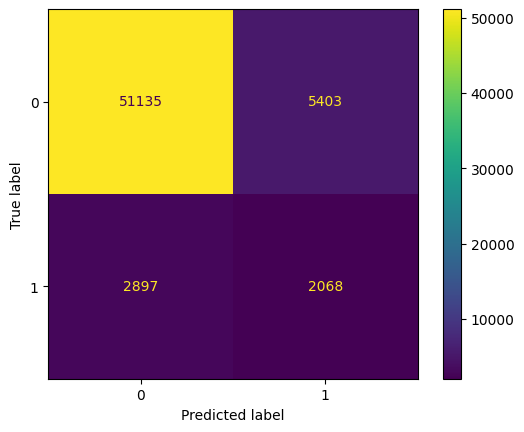

In [101]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm_final.classes_)
disp.plot()

SI CA MARCHE PAS ENLEVER CORRELATIONS